# Hypothesis Functionality

## Goals
We want a hypothesis that is:
- Simple. As few nodes as possible.
- Probable. Should have a high probability of being true

## Important Functions
- Write the Graph
- Learn the CPT Table
- ObserveData: Should be done after CPT Table is created but before hypothesis testing
- findBestExplanation given the observed data and the graph

## TO DO:
- USE SIMILARITY TO JUDGE MULTI-NODE HYPOTHESIS

In [1]:
from similarityfunctions import *
import networkx as nx
from itertools import permutations, combinations

In [2]:
# add observations to a graph
def observeData(graph, true_nodes, false_nodes):
    nodes = graph.nodes()
    for i in nodes:
        if i in true_nodes:
            graph.nodes[i]['value'] = 1
        elif i in false_nodes:
            graph.nodes[i]['value'] = 0
        else:
            graph.nodes[i]['value'] = None

In [3]:
class CPT(object):
    """
    Defines a CPT Class
    """
    def __init__(self, num_parents):
        self.num_parents = num_parents
        self.CPTable = self.make_table()
        
    def make_table(self):
        CPTable = {}
        if self.num_parents > 0:
            for i in range(2**self.num_parents):
                CPTable[bin(i)] = 0.0
        else:
            CPTable['self'] = 0.0
        return CPTable
    
    def add_entry(self, parent_values, prob):
        # values of nodes sorted in alphabetical order
        key = ''
        for i in parent_values:
            key += str(i)
        self.CPTable[bin(int(key, 2))] = prob 
    
    def add_entry_self(self, prob):
        self.CPTable['self'] = prob
    
    def get_entry(self, parent_values, value):
        key = ''
        for i in parent_values:
            key += str(i)
        return self.CPTable[bin(int(key, 2))][value]
    
    def get_entry_bin(self, parent_bin, value):
        return self.CPTable[parent_bin][value]
    
    def get_entry_self(self, value):
        return self.CPTable['self'][value]
    
    def get_table(self):
        return self.CPTable

In [4]:
from itertools import product
def calculateMarginalProbability(blanket, knodes):
    sorted_nodes = sorted(blanket.nodes())
    # want to calculate P(hyp | obs)
    # first, calculate marginal probability of P(hyp, obs, nodes)
    
    unodes = [item for item in sorted_nodes if (not item in knodes)]
    keys = list(product(range(2), repeat=len(unodes)))
    prob = 0
    for i in keys:
        p = 1
        for x in sorted_nodes:
            # find the parent values of a node
            parents = sorted(list(blanket.predecessors(x)))
            # if it has parents, get the key and get the probability
            if parents:
                # get the parents:
                parent_values = []
                for z in parents:
                    if z in knodes:
                        parent_values.append(blanket.node[z]['value'])
                    else:
                        parent_values.append(i[unodes.index(z)])
                
                parents_key = bin(int(''.join(map(str, parent_values)), 2))

                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, i[unodes.index(x)])
            # if it doesn't have parents, get the entry for itself based on the node value
            else:
                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_self(blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_self(i[unodes.index(x)])
        prob += p
    return prob

In [5]:
def calculateTotalMarginalProbability(blanket, hyp, obs, bnodes):
    # hyp | obs
    # obs | hyp
    all_obs = []
    all_obs += obs
    all_obs += hyp
    all_obs += bnodes
    new_obs = list(obs) + list(bnodes)
    num_prob = calculateMarginalProbability(blanket, all_obs)
    denom_prob = calculateMarginalProbability(blanket, new_obs)
    return num_prob / denom_prob

def calculateTotalMarginalProbabilityObs(blanket, hyp, obs, bnodes):
    all_obs = []
    all_obs += obs
    all_obs += hyp
    all_obs += bnodes
    new_hyp = list(hyp) + list(bnodes)
    num_prob = calculateMarginalProbability(blanket, all_obs)
    denom_prob = calculateMarginalProbability(blanket, new_hyp)
    return num_prob / denom_prob

In [6]:
# Finds all possible hypothesis
def combinationsList(my_list, start):
    total = []
    for i in range(start, len(my_list) + 1):
        total += list(combinations(my_list, i))
    return total

def findHypotheses(graph, observed_nodes, bnodes):
    all_node_combos = combinationsList(graph.nodes(), 1)
    hyps = []
    for i in all_node_combos:
        children = {}
        for x in i:
            children.update(get_all_children(graph, x, {}, 1))
        if all(item in children.keys() for item in observed_nodes):
            if not any(item in observed_nodes for item in i) and not any(item in bnodes for item in i):
                observed_children = {}
                for x in observed_nodes:
                    observed_children.update(get_all_children(graph, x, {}, 1))
                if not any(item in observed_children for item in i) and not too_similar(graph, i):
                    hyps.append(list(i))
    return hyps

def too_similar(graph, hyp_list, thresh=.5):
    pairs = list(combinations(hyp_list, 2))
    for pair in pairs:
        # if they're too similar
        sim_1 = get_full_similarity(graph, pair[0], pair[1])
        # print(pair, sim_1)
        if sim_1 > thresh or sim_1 == 0:
            return True
    return False

# Finds a bunch of hypothesis. Does nothing yet
def findBestExplanation(graph, observed_nodes, bnodes, flipped=False, hyps=None):
    if hyps is None:
        hyps = findHypotheses(graph, observed_nodes, bnodes)
    current_best = (None, 0)
    hyp_dict = {}
    for i in hyps:
        if isinstance(i, list) or isinstance(i, tuple): 
            for x in i:
                graph.nodes[x]['value'] = 1
            if flipped:
                prob = calculateTotalMarginalProbabilityObs(graph, list(i), observed_nodes, bnodes)
            else:
                prob = calculateTotalMarginalProbability(graph, list(i), observed_nodes, bnodes)
            for x in i:
                graph.nodes[x]['value'] = None
        else:
            graph.nodes[i]['value'] = 1
            if flipped:
                prob = calculateTotalMarginalProbabilityObs(graph, list(i), observed_nodes, bnodes)
            else:
                prob = calculateTotalMarginalProbability(graph, list(i), observed_nodes, bnodes)
            graph.nodes[i]['value'] = None
        if prob > current_best[1]:
            current_best = (i, prob)
        hyp_dict.update({tuple(i): prob})
    return (hyp_dict, current_best)

In [7]:
def hypothesisSelection(graph, observed_nodes, bnodes, n):
    # observe the data
    
    # first, o | h to
    hyp_dict, current_best = findBestExplanation(graph, observed_nodes, bnodes, flipped=True)
    # get the nth percent (4th, third, half)
    updated_hyps = {}
    lim = int(len(hyp_dict)/n)
    for i in range(lim):
        maximum = max(hyp_dict.values())
        max_key = next((key for key, val in hyp_dict.items() if maximum == val), None)
        updated_hyps.update({max_key: maximum})
        del hyp_dict[max_key]
    new_hyps, final_best = findBestExplanation(graph, observed_nodes, bnodes, hyps=updated_hyps.keys())
    return final_best

In [8]:
def graph_tests(graph, n=2):
    obs_nodes = [item for item in graph.nodes() if len(nx.ancestors(graph, item)) > 0]
    obs_nodes_combos = combinationsList(obs_nodes, 1)
    back_nodes_combos = combinationsList(graph.nodes(), 0)
    
    final_list = []
    for i in back_nodes_combos:
        for x in obs_nodes_combos:
            if not (any(item in i for item in x) and any(item in x for item in i)):
                children = get_all_children(graph, x, {}, 1)
                for i_bin in product(range(2), repeat=len(i)):
                    for x_bin in product(range(2), repeat=len(x)):
                        true_i = [i[z] for z in range(len(i_bin)) if i_bin[z] == 1] 
                        false_i = [i[z] for z in range(len(i_bin)) if i_bin[z] == 0] 
                        true_x = [x[z] for z in range(len(x_bin)) if x_bin[z] == 1] 
                        false_x = [x[z] for z in range(len(x_bin)) if x_bin[z] == 0] 
                        observeData(graph, true_i + true_x, false_i + false_x)
                        hyp, prob = hypothesisSelection(graph, x, i, n)
                        final_list.append([(true_x, false_x, true_i, false_i, hyp), prob])
    return final_list

## Testing

### Burgler Tests
Based off the example found [HERE](https://www.ics.uci.edu/~rickl/courses/cs-171/2012-wq-cs171/2012-wq-cs171-lecture-slides/2012wq171-17-BayesianNetworks.pdf)

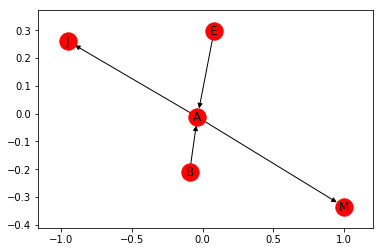

In [9]:
bdg = nx.DiGraph()
bdg.add_nodes_from(['B', 'E', 'A', 'M', 'J'])
bdg.add_weighted_edges_from([('B','A', .94002),('E','A', .29066),('A', 'M',.7),('A','J',.9)])
nx.draw_networkx(bdg)

In [10]:
# learn the CPTable

# burglar
cpt_B = CPT(0)
cpt_B.add_entry_self((1-.001, .001))
bdg.node['B']['CPT'] = cpt_B
# earthquake
cpt_E = CPT(0)
cpt_E.add_entry_self((1-.002, .002))
bdg.node['E']['CPT'] = cpt_E
#alarm
cpt_A = CPT(2)
cpt_A.add_entry([1, 1], (1-.95, .95))
cpt_A.add_entry([1, 0], (1-.94, .94))
cpt_A.add_entry([0, 1], (1-.29, .29))
cpt_A.add_entry([0, 0], (1-.001, .001))
bdg.node['A']['CPT'] = cpt_A
#john calls
cpt_J = CPT(1)
cpt_J.add_entry([1], (1-.9, .9))
cpt_J.add_entry([0], (1-.05, .05))
bdg.node['J']['CPT'] = cpt_J
#mary calls
cpt_M = CPT(1)
cpt_M.add_entry([1], (1-.7, .7))
cpt_M.add_entry([0], (1-.01, .01))
bdg.node['M']['CPT'] = cpt_M

In [11]:
observeData(bdg, ['J', 'M'], [])

In [12]:
findHypotheses(bdg, ['M', 'J'], [])

[['B'], ['E'], ['A'], ['B', 'A']]

In [13]:
findBestExplanation(bdg, ['M', 'J'], [])

({('B',): 0.2841718353643929,
  ('E',): 0.17606683840507922,
  ('A',): 0.7606920388631078,
  ('B', 'A'): 0.284157445461528},
 (['A'], 0.7606920388631078))

In [14]:
findBestExplanation(bdg, ['M', 'J'], [], flipped=True)

({('B',): 0.5922425899999999,
  ('E',): 0.18347047,
  ('A',): 0.63,
  ('B', 'A'): 0.6299999999999999},
 (['A'], 0.63))

In [15]:
hypothesisSelection(bdg, ['M', 'J'], [], n=2)

(('A',), 0.7606920388631078)

In [16]:
bdg_results_unclean = graph_tests(bdg)
bdg_results_clean = [item for item in bdg_results_unclean if item[1] != 0]

In [17]:
bdg_results_unclean

[[([], ['A'], [], [], ('E',)), 0.0014222590323639203],
 [(['A'], [], [], [], ('B',)), 0.373551228281836],
 [([], ['M'], [], [], ('E',)), 0.0015976396500871493],
 [(['M'], [], [], [], ('A',)), 0.15009011774975964],
 [([], ['J'], [], [], ('E',)), 0.0014832111079134708],
 [(['J'], [], [], [], ('A',)), 0.043437711799927066],
 [([], ['A', 'M'], [], [], ('E',)), 0.0014222590323639203],
 [(['M'], ['A'], [], [], ('E',)), 0.0014222590323639199],
 [(['A'], ['M'], [], [], ('B',)), 0.3735512282818359],
 [(['A', 'M'], [], [], [], ('B',)), 0.373551228281836],
 [([], ['A', 'J'], [], [], ('E',)), 0.0014222590323639203],
 [(['J'], ['A'], [], [], ('E',)), 0.0014222590323639199],
 [(['A'], ['J'], [], [], ('B',)), 0.373551228281836],
 [(['A', 'J'], [], [], [], ('B',)), 0.37355122828183596],
 [([], ['M', 'J'], [], [], ('E',)), 0.0014407327765951661],
 [(['J'], ['M'], [], [], ('A',)), 0.013573889331307635],
 [(['M'], ['J'], [], [], ('A',)), 0.01824973824500748],
 [(['M', 'J'], [], [], [], ('A',)), 0.7606920

In [18]:
sorted(bdg_results_clean)

[[([], ['A'], [], [], ('E',)), 0.0014222590323639203],
 [([], ['A'], [], ['J'], ('E',)), 0.0014222590323639203],
 [([], ['A'], [], ['M'], ('E',)), 0.0014222590323639203],
 [([], ['A'], [], ['M', 'J'], ('E',)), 0.0014222590323639203],
 [([], ['A'], ['J'], [], ('E',)), 0.0014222590323639199],
 [([], ['A'], ['J'], ['M'], ('E',)), 0.0014222590323639196],
 [([], ['A'], ['M'], [], ('E',)), 0.0014222590323639199],
 [([], ['A'], ['M'], ['J'], ('E',)), 0.00142225903236392],
 [([], ['A'], ['M', 'J'], [], ('E',)), 0.0014222590323639196],
 [([], ['A', 'J'], [], [], ('E',)), 0.0014222590323639203],
 [([], ['A', 'J'], [], ['M'], ('E',)), 0.0014222590323639203],
 [([], ['A', 'J'], ['M'], [], ('E',)), 0.00142225903236392],
 [([], ['A', 'M'], [], [], ('E',)), 0.0014222590323639203],
 [([], ['A', 'M'], [], ['J'], ('E',)), 0.0014222590323639203],
 [([], ['A', 'M'], ['J'], [], ('E',)), 0.0014222590323639196],
 [([], ['A', 'M', 'J'], [], [], ('E',)), 0.0014222590323639203],
 [([], ['J'], [], [], ('E',)), 0

### Sprinkler Tests
Example found [here](https://www.bayesserver.com/examples/networks/sprinkler)

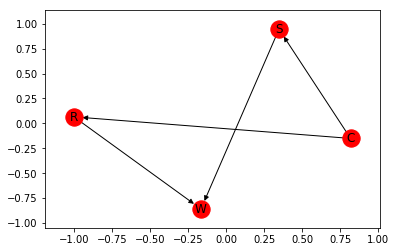

In [19]:
# make the graph
sdg = nx.DiGraph()
sdg.add_nodes_from(['C', 'S', 'R', 'W'])
sdg.add_weighted_edges_from([('C','S', 0),('C','R', 0),('S', 'W', 0),('R','W', 0)])
nx.draw_networkx(sdg)

In [20]:
# learn the CPTable

# Cloudy
cpt_C = CPT(0)
cpt_C.add_entry_self((.5, .5))
sdg.node['C']['CPT'] = cpt_C

# Rain
cpt_R = CPT(1)
cpt_R.add_entry([1], (1-.8, .8))
cpt_R.add_entry([0], (1-.2, .2))
sdg.node['R']['CPT'] = cpt_R

# Sprinkler
cpt_S = CPT(1)
cpt_S.add_entry([1], (1-.1, .1))
cpt_S.add_entry([0], (1-.5, .5))
sdg.node['S']['CPT'] = cpt_S

# Grass Wet
cpt_W = CPT(2)
cpt_W.add_entry([1, 1], (1-.99, .99))
cpt_W.add_entry([1, 0], (1-.9, .9))
cpt_W.add_entry([0, 1], (1-.9, .9))
cpt_W.add_entry([0, 0], (1, 0))
sdg.node['W']['CPT'] = cpt_W

In [21]:
# observe the data
observeData(sdg, ['W', 'C'], [])

In [22]:
# calculate the total marginal probability (both ways)
# hyp | obs
findBestExplanation(sdg, ['W'], ['C'])

({('S',): 0.13043478260869565, ('R',): 0.9758454106280193},
 (['R'], 0.9758454106280193))

In [23]:
# obs | hyp
findBestExplanation(sdg, ['W'], ['C'], flipped=True)

({('S',): 0.9720000000000001, ('R',): 0.909}, (['S'], 0.9720000000000001))

In [24]:
hypothesisSelection(sdg, ['W'], ['C'], n=1)

(('R',), 0.9758454106280193)

In [25]:
sdg_results_unclean = graph_tests(sdg)
sdg_results_clean = [item for item in sdg_results_unclean if item[1] != 0]

In [26]:
sorted(sdg_results_clean)

[[([], ['W'], [], [], ('C',)), 0.36100878435817507],
 [([], ['W'], [], ['C'], ('S',)), 0.0909090909090909],
 [([], ['W'], [], ['R'], ('C',)), 0.292604501607717],
 [([], ['W'], [], ['S'], ('C',)), 0.38066465256797577],
 [([], ['W'], ['C'], [], ('R',)), 0.2857142857142857],
 [([], ['W'], ['R'], [], ('C',)), 0.8687350835322196],
 [([], ['W'], ['S'], [], ('C',)), 0.0639269406392694],
 [(['W'], [], [], [], ('S',)), 0.4297635605006954],
 [(['W'], [], [], ['C'], ('R',)), 0.3442622950819672],
 [(['W'], [], [], ['R'], ('S',)), 1.0],
 [(['W'], [], [], ['S'], ('R',)), 1.0],
 [(['W'], [], ['C'], [], ('S',)), 0.13043478260869565],
 [(['W'], [], ['R'], [], ('S',)), 0.19449901768172886],
 [(['W'], [], ['S'], [], ('R',)), 0.3203883495145631]]

In [41]:
# test grass is wet and is cloudy
observeData(sdg, ['W', 'C'], [])
findBestExplanation(sdg, ['W'], ['C'])

({('S',): 0.13043478260869565, ('R',): 0.9758454106280193},
 (['R'], 0.9758454106280193))

In [42]:
findBestExplanation(sdg, ['W'], ['C'], flipped=True)

({('S',): 0.9720000000000001, ('R',): 0.909}, (['S'], 0.9720000000000001))

### Asia Tests
Example found [here](https://www.bayesserver.com/examples/networks/asia)

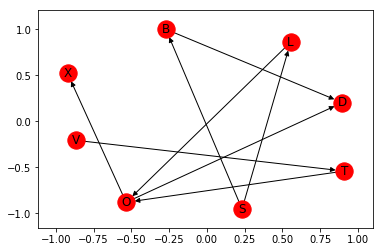

In [27]:
# make the graph
adg = nx.DiGraph()
adg.add_nodes_from(['V', 'T', 'S', 'L', 'B', 'O', 'X', 'D'])
adg.add_weighted_edges_from([('V','T', 0),('T','O', 0),('O','X', 0),
                             ('O','D', 0), ('S','L', 0), ('S','B', 0),
                            ('L','O', 0), ('B','D', 0)])
nx.draw_networkx(adg)

In [28]:
# learn the CPTable

# Visit to Asia
cpt_V = CPT(0)
cpt_V.add_entry_self((.99, .01))
adg.node['V']['CPT'] = cpt_V

# Smoker
cpt_S = CPT(0)
cpt_S.add_entry_self((.5, .5))
adg.node['S']['CPT'] = cpt_S

# Tuburculosis
cpt_T = CPT(1)
cpt_T.add_entry([1], (1-.05, .05))
cpt_T.add_entry([0], (1-.01, .01))
adg.node['T']['CPT'] = cpt_T

# Lung Cancer
cpt_L = CPT(1)
cpt_L.add_entry([1], (1-.1, .1))
cpt_L.add_entry([0], (1-.01, .01))
adg.node['L']['CPT'] = cpt_L

# Bronchitus
cpt_B = CPT(1)
cpt_B.add_entry([1], (1-.6, .6))
cpt_B.add_entry([0], (1-.3, .3))
adg.node['B']['CPT'] = cpt_B

# Tub or Cancer
cpt_O = CPT(2)
cpt_O.add_entry([1, 1], (.01, .99))
cpt_O.add_entry([1, 0], (.01, .99))
cpt_O.add_entry([0, 1], (.01, .99))
cpt_O.add_entry([0, 0], (.99, .01))
adg.node['O']['CPT'] = cpt_O

# Dyspena
cpt_D = CPT(2)
cpt_D.add_entry([1, 1], (1-.9, .9))
cpt_D.add_entry([1, 0], (1-.8, .8))
cpt_D.add_entry([0, 1], (1-.7, .7))
cpt_D.add_entry([0, 0], (1-.1, .1))
adg.node['D']['CPT'] = cpt_D

# Xray result
cpt_X = CPT(1)
cpt_X.add_entry([1], (1-.98, .98))
cpt_X.add_entry([0], (1-.05, .05))
adg.node['X']['CPT'] = cpt_X

In [29]:
# observe the data
observeData(adg, ['O'], ['T', 'L'])

In [36]:
# multiple tests
adg_results_unclean = graph_tests(adg)
adg_results_clean = [item for item in adg_results_unclean if item[1] != 0]

In [73]:
final_results = {}
for i in bdg_results_clean:
    new_i = []
    for x in i[0]:
        new_i.append(tuple(x))
    new_i = tuple(new_i)
    if new_i in final_results.keys():
        final_results[new_i].append(i)
    else:
        final_results[new_i] = [i]


[Text(0, 0, "((), ('A',), (), (), ('E',))"),
 Text(0, 0, "(('A',), (), (), (), ('B',))"),
 Text(0, 0, "((), ('M',), (), (), ('E',))"),
 Text(0, 0, "(('M',), (), (), (), ('A',))"),
 Text(0, 0, "((), ('J',), (), (), ('E',))"),
 Text(0, 0, "(('J',), (), (), (), ('A',))"),
 Text(0, 0, "((), ('A', 'M'), (), (), ('E',))"),
 Text(0, 0, "(('M',), ('A',), (), (), ('E',))"),
 Text(0, 0, "(('A',), ('M',), (), (), ('B',))"),
 Text(0, 0, "(('A', 'M'), (), (), (), ('B',))")]

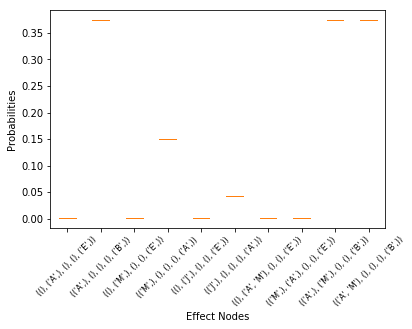

In [78]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Probabilities')
ax1.set_xlabel('Effect Nodes')
ax1.boxplot(all_data[:int(len(all_data)/16)])
ax1.set_xticklabels(list(final_results.keys())[:int(len(final_results.keys())/16)],
                    rotation=45, fontsize=8)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Probabilities')
ax1.set_xlabel('Effect Nodes')
ax1.boxplot(all_data[int(len(all_data)/2):int(3*len(all_data)/4)])
ax1.set_xticklabels(list(final_results.keys())[int(len(final_results.keys())/2):int(3*len(final_results.keys())/4)],
                    rotation=45, fontsize=8)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Probabilities')
ax1.set_xlabel('Effect Nodes')
ax1.boxplot(all_data[int(3*len(all_data)/4):])
ax1.set_xticklabels(list(final_results.keys())[int(3*len(final_results.keys())/4):],
                    rotation=45, fontsize=8)

## Export data with Pandas

In [58]:
import pandas as pd

In [64]:
def convert(lst):
    final_results = {}
    for i in lst:
        new_i = []
        for x in i[0]:
            new_i.append(tuple(x))
        new_i = tuple(new_i)
        final_results[new_i] = i[1]

    #res_dct = {tuple(lst[i]): lst[i] for i in range(0, len(lst))} 
    return final_results

In [66]:
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in dict_adg_results_clean.items() })
dict_df.to_csv(r'asia_graph_hypothesis_results_updated.csv', index = False, header=True)

In [69]:
dict_bdg_results_clean = convert(bdg_results_clean)

In [70]:
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in dict_bdg_results_clean.items() })
dict_df.to_csv(r'burglar_graph_hypothesis_results.csv', index = False, header=True)

In [72]:
dict_sdg_results_clean = convert(sdg_results_clean)
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in dict_sdg_results_clean.items() })
dict_df.to_csv(r'sprinkler_graph_hypothesis_results.csv', index = False, header=True)

# Unused Stuff

In [ ]:
# adds new true nodes and new false nodes to the graph and then checks for contradictions
# only finds direct contraidctions? Should talk with group about this.
import copy 
def findContradictions(graph, new_true_nodes, new_false_nodes, threshold=.5):
    new_g = copy.deepcopy(graph)
    observeData(new_g, new_true_nodes, new_false_nodes)
    edge_attrs = nx.get_edge_attributes(new_g, 'weight')
    for i in new_g.nodes():
        if 'observed' in new_g.nodes.data()[i]:
            if new_g.nodes.data()[i]['observed'] is True:
                for x in edge_attrs:
                    print(x, x[1], new_g.nodes.data()[x[1]], edge_attrs[x])
                    if 'observed' in new_g.nodes.data()[x[1]]:
                        if x[0] == i and new_g.nodes.data()[x[1]]['observed'] is False and edge_attrs[x] >= threshold:
                            return (i, True, x[1], False, edge_attrs[x])
    return "No contradictions found"

In [ ]:
# sees if some nodes are independent based on the nodes we are conditioning on
# we are only checking for *direct* conditions. chains are not accounted for
# since in baysien networks edges are "direct dependence." Should double-check this.
def independenceChecker(graph, conditions, nodes):
    edges = nx.get_edge_attributes(graph, 'weight')
    for i in edges:
        if i[1] in nodes and not i[0] in conditions:
            return False
    return True

In [ ]:
def getMarkovBlanket(graph, obs, hyp):
    #generates a new graph (markov blanket) based on the graph, observations, and hypothesis
    #get all parent nodes
    edge_attrs = nx.get_edge_attributes(graph, 'weight')
    new_graph = nx.DiGraph()
    new_graph.add_node(hyp)
    new_graph.add_nodes_from(obs)
    for i in edge_attrs:
        if i[0] in obs or i[0] == hyp:
            new_graph.add_node(i[1])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
        if i[1] in obs or i[1] == hyp:
            new_graph.add_node(i[0])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
    return new_graph